# <center> SIP1 - Position Management Quantitative Model </center> 
## <center>By 0xEvan(∞)#4567</center>  

3/3/22 - TODO - Need to swap csv data for a better source of data. Current CSV data is currently out of date, just serves as proof of concept

# Import Data

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from datetime import datetime, date, timedelta
from matplotlib.pyplot import figure

In [ ]:
# Mount google drive to access the dataset, which is saved on google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ohm_market_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/olympus_market_fluidsonic.csv' 
new_csi_file = 'gdrive/My Drive/Colab Notebooks/concave_ohm_rebase_data/new_csi.csv'

In [ ]:
# read csv files as dataframes
new_csi_df = pd.read_csv(new_csi_file)
ohm_market_df = pd.read_csv(ohm_market_file)
ohm_market_df = ohm_market_df[['timestamp', 'indexed_price_usd']]

# set indexes
new_csi_df['time'] = pd.to_datetime(new_csi_df['time']).dt.normalize()
new_csi_df = new_csi_df.set_index('time')

ohm_market_df['timestamp'] = pd.to_datetime(ohm_market_df['timestamp']).dt.normalize()
ohm_market_df['timestamp'] = ohm_market_df['timestamp'].dt.tz_localize(None)
ohm_market_df = ohm_market_df.set_index('timestamp')

# trim csi rows to match ohm_backtest_df rows
ohm_market_df = ohm_market_df[ohm_market_df.index >= '2021-10-01']


# drop last row, it's duplicate
new_csi_df = new_csi_df[:-1]
new_csi_df = new_csi_df.dropna()

In [ ]:
from scipy import stats

def get_percentile_col(df, col_name):
  ''' adds percentile column to dataframe'''
  data_list = df[col_name].tolist()
  percentiles_list = []
  for i in range(len(data_list)):
    val = stats.percentileofscore(data_list, data_list[i])
    percentiles_list.append(val)
  
  new_col_name = col_name + '_percentile'
  df[new_col_name] = percentiles_list
  return df

In [ ]:
# make portfolio allocation curve
new_csi_df_cut = new_csi_df[['signal_15d', 'signal_30d', 'signal_60d']]
new_csi_df_cut['signal_60d_trend'] = new_csi_df_cut['signal_60d'] > new_csi_df_cut['signal_60d'].mean()
new_csi_df_cut['signal_60d_abs'] = new_csi_df_cut['signal_60d'].abs()
new_csi_df_cut_abs = get_percentile_col(new_csi_df_cut, 'signal_60d_abs')

# make trade signal column
new_csi_df_cut_abs['trade_signal'] = new_csi_df_cut_abs['signal_15d'] > new_csi_df_cut_abs['signal_30d'] # when 15d > 30d, sell. When 30d > 15day, buy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
new_csi_df_cut_abs

,signal_15d,signal_30d,signal_60d,signal_60d_trend,signal_60d_abs,signal_60d_abs_percentile,trade_signal
time,,,,,,,
2020-03-31,0.000022,0.000010,0.000018,True,0.000018,29.893778,True
2020-04-01,-0.000010,-0.000023,-0.000002,False,0.000002,5.007587,True
2020-04-02,-0.000047,-0.000024,-0.000025,False,0.000025,37.177542,False
2020-04-03,-0.000046,-0.000017,-0.000008,False,0.000008,17.298938,False
2020-04-04,-0.000013,-0.000023,-0.000006,False,0.000006,11.836115,True
...,...,...,...,...,...,...,...
2022-01-14,0.000004,-0.000042,0.000131,True,0.000131,78.452200,True
2022-01-15,-0.000004,0.000044,0.000208,True,0.000208,90.743551,False
2022-01-16,-0.000042,0.000033,0.000144,True,0.000144,81.031866,False


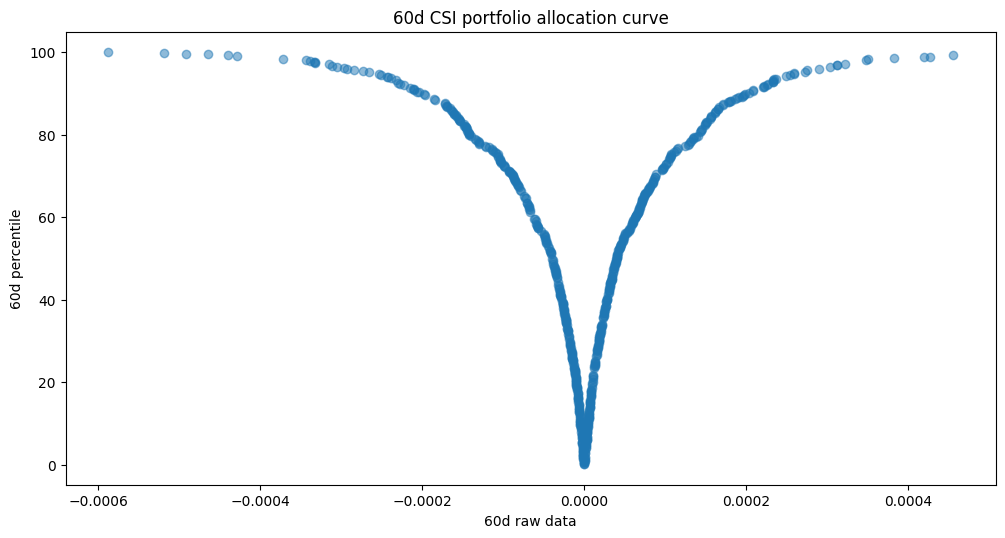

In [ ]:
figure(figsize = (12, 6), dpi = 100)
plt.scatter(new_csi_df_cut_abs['signal_60d'], new_csi_df_cut_abs['signal_60d_abs_percentile'], alpha=0.5)
plt.xlabel("60d raw data")
plt.ylabel("60d percentile")
plt.title("60d CSI portfolio allocation curve")
plt.show()

In [ ]:
class backtest_model:
  def __init__(self, backtest_df, model_df, buy_trade_size = .1, sell_trade_size = .1, stable_apy = .2, slippage = .0025, gas=.01):
    '''
    backtest_df = Holds data for backtesting. Needs the following columns=['ohmPrice', 'rebasePercentage']
    model_df = Contains the signal that trades will be executed on
    '''
    self.backtest_df = backtest_df
    self.model_df = model_df
    self.trades_df = None
    self.optimal_stable_ratio_df = None

    self.buy_trade_size = buy_trade_size # buy/sell trade size variables will disappear
    self.sell_trade_size = sell_trade_size
    self.stable_apy = stable_apy
    self.slippage = slippage
    self.gas = gas

    self.stable_ratio_mean = .5
    self.stable_ratio_bounds = .3


  def calc_portfolio_value(self, token_amount, stable, token_price):
    '''
    Rebase should be denominated in USD
    '''
    return (token_amount * token_price) + stable 

  def calc_trades(self):
    '''
    calculates trades based on self.model_df signal data. Must manually assign this to self.trades_df outside of the class. 
    Problem is noted and needs to be fixed in the future (unknown bug issue)
    '''
    count = 0
    buy_strength = 0
    buy_list = []
    for index, row in self.model_df.iterrows():
      count += 1
      if count < 5:
        if row['trade_signal'] == True:
          buy_strength +=1
        if row['trade_signal'] == False:
          buy_strength -= 1
      else:
        if buy_strength >= 2:
          buy_list.append((index, True))
        if buy_strength <= -2:
          buy_list.append((index, False))
        count = 0
        buy_strength = 0
    
    # turn list of tuples into dataframe
    df = pd.DataFrame(buy_list, columns=["datetime", "trade_signal"])
    df["datetime"] = pd.to_datetime(df["datetime"]).dt.normalize()
    df = df.set_index("datetime")
    return df

  def get_optimal_stable_ratio(self, trend, abs_percent):
    '''
    optimize trade towards ideal ratio. 
    trend = boolean
    abs_percent = absolute percent from allocation curve
    '''
    if trend == True:
      optimal_stable_ratio = self.stable_ratio_mean - (abs_percent/100 * self.stable_ratio_bounds) 
    if trend == False:
      optimal_stable_ratio = self.stable_ratio_mean + (abs_percent/100 * self.stable_ratio_bounds)
    return optimal_stable_ratio

  def calc_optimal_stable_ratio(self):
    '''
    calculate optimal stable ratio
    '''
    optimal_stable_ratio_his = []
    for index, row in self.model_df.iterrows():
      optimal_stable_ratio = self.get_optimal_stable_ratio(row['signal_60d_trend'], row['signal_60d_abs_percentile'])
      optimal_stable_ratio_his.append(optimal_stable_ratio)
    return optimal_stable_ratio_his

  def get_stable_ratio(self, token_amount, token_price, stable_amount):
    return stable_amount / ((token_amount * token_price) + stable_amount)


  def run_backtest_no_rebase(self, token_initial, stable_initial, vanilla=False):
    sim_result = pd.DataFrame(columns=['token_amount', 'stable_amount', 'indexed_price_usd', 'stable_ratio', 'portfolio_value']) #  ADD IN 'optimal_stable_ratio'
    # trades execution count
    trades_counter = 0
    # initial backtest data
    token_amount = token_initial
    stable_amount = stable_initial
    # stable_ratio = self.get_stable_ratio(token_amount, self.backtest_df['indexed_price_usd'][0], stable_amount)
    # portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, self.backtest_df['indexed_price_usd'][0]) -- I think this is redundant, might not need this

    # run through backtest data
    for index, row in self.backtest_df.iterrows():
      # update values
      stable_yield = stable_amount * (self.stable_apy / 365)
      stable_amount += stable_yield
      stable_ratio = self.get_stable_ratio(token_amount, row['indexed_price_usd'], stable_amount) 
      portfolio_value = self.calc_portfolio_value(token_amount, stable_amount, row['indexed_price_usd'])

      if vanilla == False:
      # verify whether to trade
        # print("index", index, "self_trades_df.index", self.trades_df.index[0])
        if index == self.trades_df.index[0] and self.trades_df.index.size != 0:
          self.trades_df = self.trades_df.tail(self.trades_df.shape[0] -1)
          trades_counter +=1
          # Execute trade
          if self.trades_df['trade_signal'][0] == True:
            # initial trade params
            order_size = stable_amount * self.buy_trade_size # trade is set at default 10% trading size
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage
            buy_size = order_size/row['indexed_price_usd'] # 1/19/22 NEEDS TO BE REDONE

            # calculate trade 1/19/22 NEEDS TO BE REDONE
            token_amount += buy_size
            stable_amount -= order_size - gas_fee - slippage_fee
          elif self.trades_df['trade_signal'][0] == False:
            # initial trade params
            order_size = stable_amount * self.sell_trade_size # trade is set at default 10% trading size
            sell_size = order_size/row['indexed_price_usd'] # 1/19/22 NEEDS TO BE REDONE
            gas_fee = order_size * self.gas
            slippage_fee = order_size * self.slippage

            # calculate trade 1/19/22 NEEDS TO BE REDONE
            token_amount -= sell_size
            stable_amount += order_size - gas_fee - slippage_fee

      # update results
      sim_result.loc[sim_result.index.size] = (token_amount, stable_amount, row['indexed_price_usd'], stable_ratio, portfolio_value)


    # finish up function
    sim_result.index = self.backtest_df.index
    print("trades_counter", trades_counter)

    return sim_result

## gohm simulation

In [ ]:
# make csi_df same length as ohm_market
backtest_length = ohm_market_df.index.size
new_csi_df_cut_abs = new_csi_df_cut_abs[-backtest_length:]

In [ ]:
# cut off data to be less than trade_signal data
ohm_market_df = ohm_market_df[:-5]

In [ ]:
# gohm simulation!
start_gohm_price = ohm_market_df['indexed_price_usd'].iloc[0]

# starting position is 100k USD total value
starting_stablecoin_value = 50000
starting_gohm_position = 50000/start_gohm_price

# instantiate model classes
model_balanced_gohm = backtest_model(ohm_market_df, new_csi_df_cut_abs, buy_trade_size = .1, sell_trade_size = .1)
model_conservative_gohm = backtest_model(ohm_market_df, new_csi_df_cut_abs, buy_trade_size = .1, sell_trade_size = .3)
model_aggressive_gohm = backtest_model(ohm_market_df, new_csi_df_cut_abs, buy_trade_size = .3, sell_trade_size = .1)
model_vanilla_gohm = backtest_model(ohm_market_df, new_csi_df_cut_abs)


# generate trades
trades_df_gohm = model_balanced_gohm.calc_trades()

# set trades for non-vanilla models
model_balanced_gohm.trades_df = trades_df_gohm
model_conservative_gohm.trades_df = trades_df_gohm
model_aggressive_gohm.trades_df = trades_df_gohm

In [ ]:
# generate optimal stablecoin ratio
my_list = model_balanced_gohm.calc_optimal_stable_ratio()
# set ratio for models?

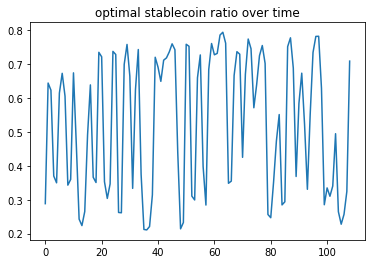

In [ ]:
# this is a daily thing 
plt.plot(my_list)
plt.title("optimal stablecoin ratio over time");

In [ ]:
print(ohm_market_df.index.size)

104


In [ ]:
my_list = my_list[:-5]

In [ ]:
print(len(my_list))

104


In [ ]:
STOP
# NEED TO IMPLEMENT CUSTOM TRADING SIZE BASED ON OPTIMAL STABLECOIN RATIO

NameError: ignored

In [ ]:
results_df_balanced_gohm = model_balanced_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_conservative_gohm = model_conservative_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_aggressive_gohm = model_aggressive_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value)
results_df_vanilla_gohm = model_vanilla_gohm.run_backtest_no_rebase(starting_gohm_position, starting_stablecoin_value, vanilla=True)

trades_counter 13
trades_counter 13
trades_counter 13
trades_counter 0


In [ ]:
results_df_balanced_gohm.columns

Index(['token_amount', 'stable_amount', 'indexed_price_usd', 'stable_ratio',
       'portfolio_value'],
      dtype='object')

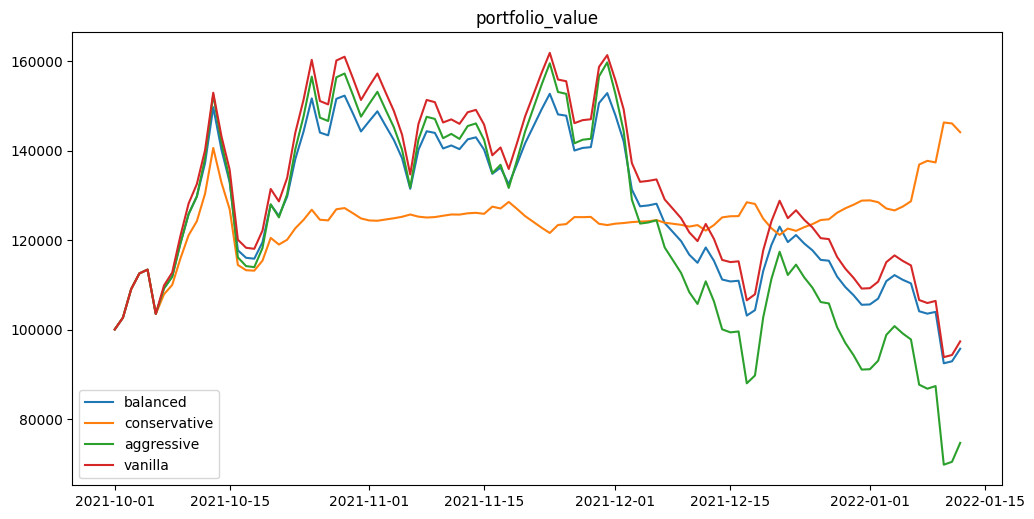

In [ ]:
x = results_df_vanilla_gohm.index
y1 = results_df_balanced_gohm['portfolio_value']
y2 = results_df_conservative_gohm['portfolio_value']
y3 = results_df_aggressive_gohm['portfolio_value']
y4 = results_df_vanilla_gohm['portfolio_value']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("portfolio_value")
plt.legend()
plt.show()

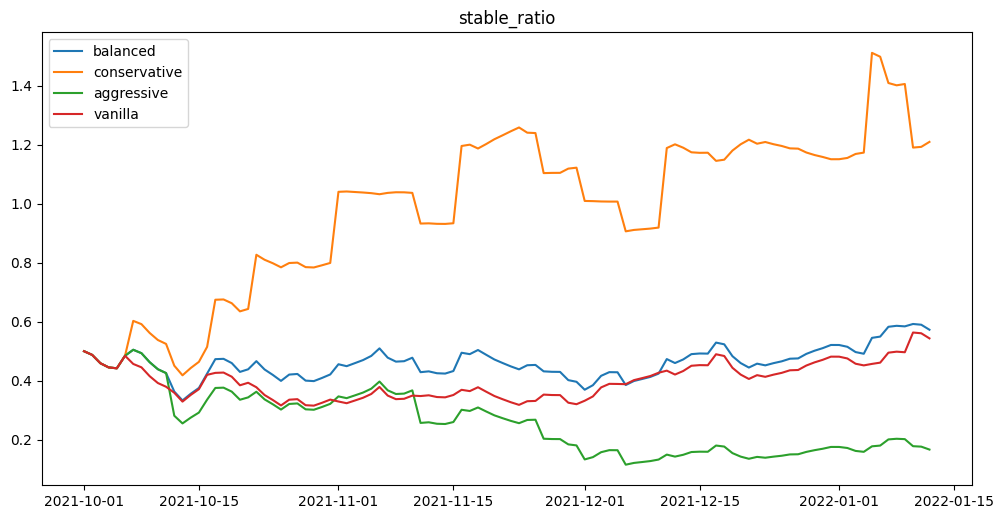

In [ ]:
x = results_df_vanilla_gohm.index
y1 = results_df_balanced_gohm['stable_ratio']
y2 = results_df_conservative_gohm['stable_ratio']
y3 = results_df_aggressive_gohm['stable_ratio']
y4 = results_df_vanilla_gohm['stable_ratio']

figure(figsize = (12, 6), dpi = 100)
plt.plot(x, y1, label='balanced')
plt.plot(x, y2, label='conservative')
plt.plot(x, y3, label='aggressive')
plt.plot(x, y4, label='vanilla')
plt.title("stable_ratio")
plt.legend()
plt.show()

In [ ]:
results_df_conservative_gohm['stable_amount'][-1]

174423.5473286563

In [ ]:
results_df_conservative_gohm.tail(1)

,token_amount,stable_amount,indexed_price_usd,portfolio_value
timestamp,,,,
2022-01-12,-2.285729,174423.547329,13250.811323,144135.78734
